# Horizonts detection model

## Content

* [Problem description](description)
* [Dataset](dataset)
* [Model architecture](architecture)
* [Training](training)
* [Validation](validation)
* [Criticism](criticism)
* [Conclusion](conclusion)
* [Suggestions for improvements](suggestions)


<a id='description'></a>

# Problem description

Seismic horizon is a change in rock properties across a boundary between two layers of rock, particularly seismic velocity and density. Such changes are visible in seismic images (even for an untrained eye), and could be automatically detected. 
This notebook demonstrates how to build convolutional neural network that detects all of the horizonts on the given cube.

<img src="imgs/unlabeled_slide.png" alt="Drawing" style="width: 400px; height: 400px"/>

<a id='dataset'></a>

# Dataset

We use multiple seismic cubes, in particular, Cube 1, Cube 3 and Cube VU_ONGMK, for training. A number of hand-labelled horizonts goes along with each cube, and can be seen on image below. Detailed description of each cube, including more sample images, is available [here](./../datasets/Horizonts_modelling.ipynb).

<img src="imgs/labeled_slide.jpg" alt="Drawing" style="width: 400px; height: 400px"/>

Importantly, each cube is too big to fit into the GPU memory, so we must cut small crops out of it in order to train the model. This changes whole pipeline of research: we need convenient methods of:
* splitting seismic cubes into crops of desired shape
* lazy loading crops into memory (with quite hard memory constraints)
* training model on labeled crops
* predicting with trained model on unlabeled crops
* assemble predictions back into the whole cube

`Seismiqb` package provides exactly this. Some examples of ready-to-use pipelines can be found [here.](./../tutorials/2.%20Batch.ipynb)

**Note:** we heavily rely on [BatchFlow](https://github.com/analysiscenter/batchflow) to define sophisticated neural network architectures with just a few lines of code.

In [1]:
# Necessary imports
import os
import sys
import warnings
import logging
import json

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from glob import glob
from tqdm import tqdm

sys.path.append('..')
from seismiqb.batchflow import Pipeline, FilesIndex
from seismiqb.batchflow import B, V, C, L, F, D, P, R
from seismiqb.batchflow.models.tf import *
from seismiqb.batchflow.models.tf.layers import conv_block
from seismiqb import SeismicCropBatch, SeismicGeometry, SeismicCubeset

warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

%env CUDA_VISIBLE_DEVICES=4

env: CUDA_VISIBLE_DEVICES=4


First of all, we get information about each cube geometry, preprocess `.txt` labels and lay out some inner structure. To learn more about `SeismicCubeset` and its capabilities, check [this](./../tutorials/1.%20Cubeset.ipynb) tutorial out.

As we want to train model more on harder data, different proportions for cubes for sampling points from are set: we want to train not as often on Cube 3 due to its simplicity.

In [2]:
paths_cubes = ['/notebooks/SEISMIC_DATA/CUBE_1/E_anon.hdf5',
               '/notebooks/SEISMIC_DATA/CUBE_3/P_cube.hdf5',
               '/notebooks/SEISMIC_DATA/CUBE_VUONGMK/Repaired_cube.hdf5']

dsi = FilesIndex(path=paths_cubes, no_ext=True)
ds = SeismicCubeset(dsi)


paths_txt = {ds.indices[0]: glob('/notebooks/SEISMIC_DATA/CUBE_1/FORMAT_HORIZONTS/*'),
             ds.indices[1]: glob('/notebooks/SEISMIC_DATA/CUBE_3/FORMAT_HORIZONTS/*'),
             ds.indices[2]: glob('/notebooks/SEISMIC_DATA/CUBE_VUONGMK/FORMAT_HORIZONTS/*'),}

ds = (ds.load_geometries()
        .load_point_clouds(paths = paths_txt)
        .load_labels()
        .load_samplers(p=[0.4, 0.2, 0.4])
      )
# ~80 seconds

<a id='architecture'></a>

# Model architecture

We use convonlutional neural network in `EncoderDecoder` fashion and train on crops of (256, 256, 2) size:
* First of all, initial crop is downsampled twice along xlines/heights dimensions, effectively reducing resolution 4 times
* Then, we encode crop by applying `inception_a_block` of Inception_v4 3 times with max-pooling in-between
* `Inception_c_block` is applied at the bottleneck
* Initial shape of the block is restored by transposed convolutions with ordinary convolutions+batchnorm+activation(ReLU) in-between

Multiple things are worth noting. Most importantly, model percieves every crop (a 3-d entity) as sequence of 2-d images stacked one after the other, and every convolution that is used is 2D.
Every max-pooling in the network is of size and stride 2, effectively halving the resolution of its inputs. To get precise definitions of `Inception` blocks, check [this](https://arxiv.org/pdf/1602.07261.pdf) paper.

Technical note: in order to compute `Dice`-coefficient, we need to add axis both to the output of neural network and to initial labels. That is done via `predictions` callable in the first case and `add_axis` action in the second.

In [3]:
# Global constants
EPOCHS = 1500
NUM_CROPS = 64
CROP_SHAPE = (2, 256, 256) # i, x, h

In [4]:
# Custom ED class is to ensure that `head` block does not `crop` its inputs. 
# For more on that, check the `head` method of EncoderDecoder
class ED(EncoderDecoder):
    @classmethod
    def head(cls, inputs, targets, name='head', **kwargs):
        kwargs = cls.fill_params('head', **kwargs)
        with tf.variable_scope(name):
            channels = cls.num_channels(targets)
            x = conv_block(inputs, filters=channels, **kwargs)
        return x


# ED config
def predictions(x):
    return tf.expand_dims(x, axis=-1, name='expand')

model_config = {
    'inputs': dict(cubes={'shape': (None, None, CROP_SHAPE[0])},
                   masks={'name': 'targets', 'shape': (None, None, CROP_SHAPE[0], 1)}), 
    'initial_block/inputs': 'cubes',
    'initial_block': {'layout': 'pp'},
    'body/encoder': {'num_stages': 3,
                     'blocks': {'base': Inception_v4.inception_a_block,
                                'filters': [[32, 16], [48, 32], [64, 48]]}},
    'body/embedding': {'base': Inception_v4.inception_c_block, 'filters': [32, 48, 64, 96]},
    'body/decoder': {'num_stages': 5, 'blocks': {'layout':'cna', 'filters': [32, 16, 8, 6, 4]}},
    'loss': 'dice',
    'optimizer': 'Adam',
    'predictions': predictions,
    'output': 'sigmoid',
    'common': {'data_format': 'channels_last'},
    'microbatch': 32,
}

pipeline_config = {'model': ED,
                   'model_config': model_config,
                   'num_crops': NUM_CROPS}

<a id='training'></a>

# Training

Neural network is trained on crops of fixed shape. Pipeline consists of following steps:
* First of all, we initialize all the pipeline variables, that we need, and the model itself
* Then, we create positions of crops, then load actual data and labels for it. Data is immediately scaled to $[0, 1]$ range in order to normalize values from different cubes
* Right after, multiple augmentations are applied to simulate different distortions and make model robust to them
* Model weights update

Every batch contains 64 crops. Model is trained for 1500 epochs with `Adam` optimizer with default parameters. Loss-function: `Dice`-coefficient.


In [5]:
train_pipeline = (Pipeline(config=pipeline_config)
                  # Initialize pipeline variables and model
                  .init_variable('loss_history', init_on_each_run=list)
                  .init_variable('current_loss')
                  .init_model('dynamic', C('model'), 'ED', C('model_config'))
                  # Load data/masks
                  .load_component(src=[D('geometries'), D('labels')],
                                  dst=['geometries', 'labels'])
                  .crop(points=L(ds.sampler.truncate(high=0.8, expr=lambda p: p[:, 1]).sample, NUM_CROPS),
                        shape=CROP_SHAPE)
                  .load_cubes(dst='data_crops')
                  .create_masks(dst='mask_crops', width=1)
                  .rotate_axes(src=['data_crops', 'mask_crops'])
                  .scale(mode='normalize', src='data_crops')
                  # Augmentations
                  .additive_noise(scale=0.005,
                                  src='data_crops', dst='data_crops', p=0.2)
                  .rotate(angle=P(R('uniform', -30, 30)),
                          src=['data_crops', 'mask_crops'], p=0.4)
                  .scale_2d(scale=P(R('uniform', 0.7, 1.3)),
                            src=['data_crops', 'mask_crops'], p=0.4)
                  .cutout_2d(patch_shape=P(R('uniform', 10, 30, size=2)), n=P(R('uniform', 3, 17)),
                             src='data_crops', p=0.2)
                  .elastic_transform(alpha=P(R('uniform', 35, 45)), sigma=P(R('uniform', 4, 4.5)),
                                     src=['data_crops', 'mask_crops'], p=0.2)
                  # Training
                  .add_axis(src='mask_crops', dst='mask_crops')
                  .train_model('ED', 
                               fetches='loss',
                               make_data={'cubes': B('data_crops'), 'masks': B('mask_crops')},
                               save_to=V('current_loss'))
                  .update_variable('loss_history', 
                                   V('current_loss'), 
                                   mode='a')) << ds
loss_history = []

In [6]:
# Training loop. Allows to see progress (value of loss)
with tqdm(total=EPOCHS, smoothing=0.3) as pbar:
    for e in range(1, EPOCHS+1):
        train_batch = train_pipeline.next_batch(3, n_epochs=None)
        current_loss = train_pipeline.get_variable("current_loss")
        loss_history.append(current_loss)

        pbar.set_description('Loss:{:12.7}'.format(current_loss))
        pbar.update(1)

Loss:  -0.7979323: 100%|██████████| 1500/1500 [1:29:14<00:00,  3.37s/it]


Loss against iterations:

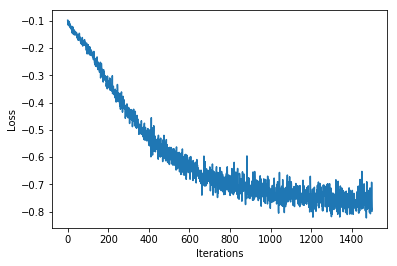

In [7]:
plt.plot(loss_history)
plt.xlabel("Iterations"), plt.ylabel("Loss")
plt.show()

As we can see, loss starts to plateau after just 90 minutes of training. Relatively high variance suggests that model can benefit from bigger batch size.

<a id='validation'></a>

# Validation

Now, we want to check performance of our model on unseen part of the cubes. 

In [8]:
val_pipeline = (Pipeline()
                # Initialize everything
                .init_variable('result', init_on_each_run=list()) 
                .import_model('ED', train_pipeline)
                # Load data/masks
                .load_component(src=[D('geometries'), D('labels')],
                                dst=['geometries', 'labels'])
                .crop(points=L(ds.sampler.truncate(low=0.9, expr=lambda p: p[:, 1], prob=0.1).sample, NUM_CROPS),
                      shape=CROP_SHAPE)
                .load_cubes(dst='data_crops')
                .create_masks(dst='mask_crops')
                .rotate_axes(src=['data_crops', 'mask_crops'])
                .scale(mode='normalize', src='data_crops')
                # Predict with model
                .add_axis(src='mask_crops', dst='mask_crops')
                .predict_model('ED', 
                               fetches=['cubes', 'masks', 'predictions', 'loss'],
                               make_data={'cubes': B('data_crops'), 'masks': B('mask_crops')}, 
                               save_to=V('result', mode='a'))
                ) << ds

val_batch = val_pipeline.next_batch(3, n_epochs=None)

Loss is:  -0.50291944
P_cube


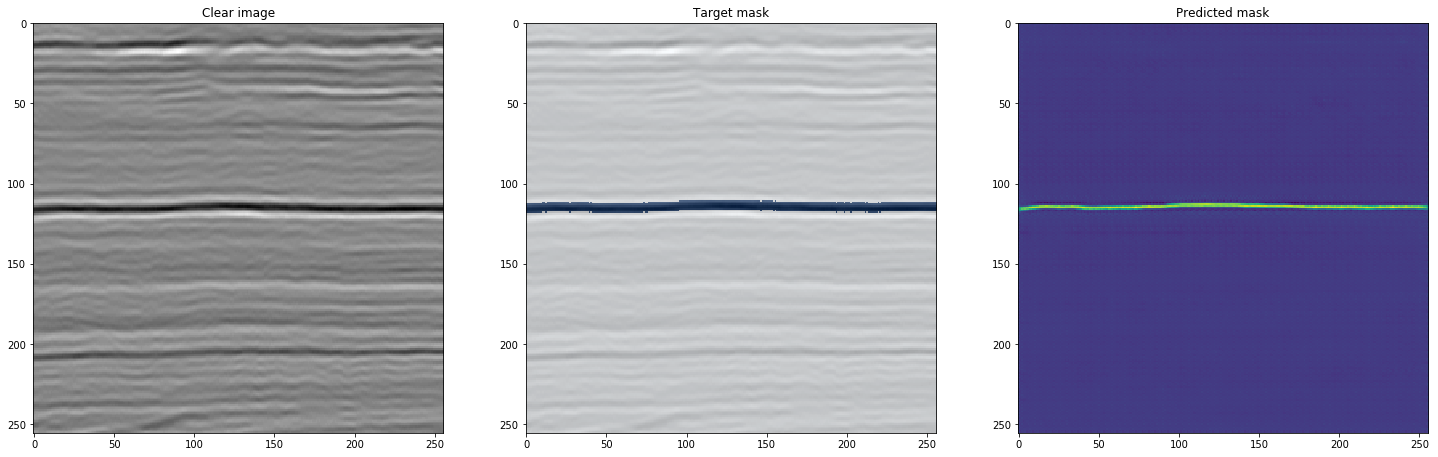

E_anon


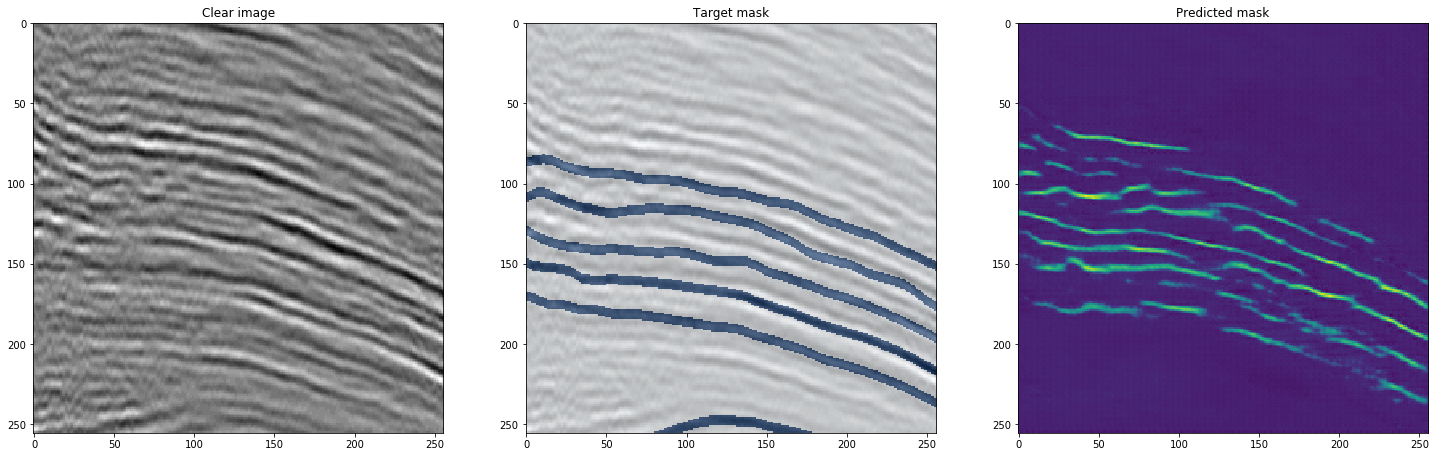

E_anon


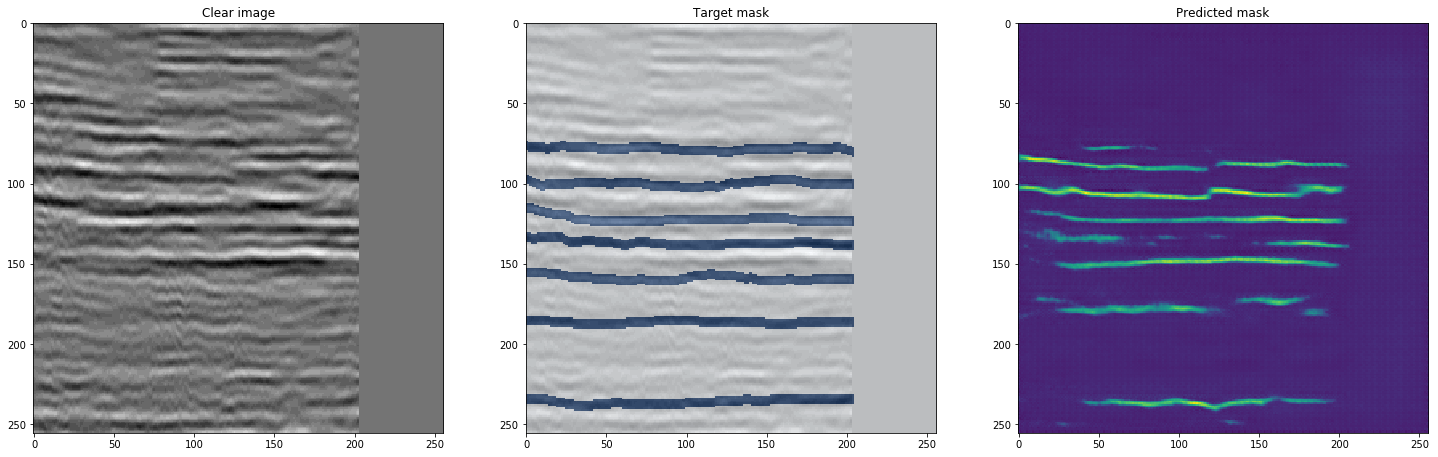

E_anon


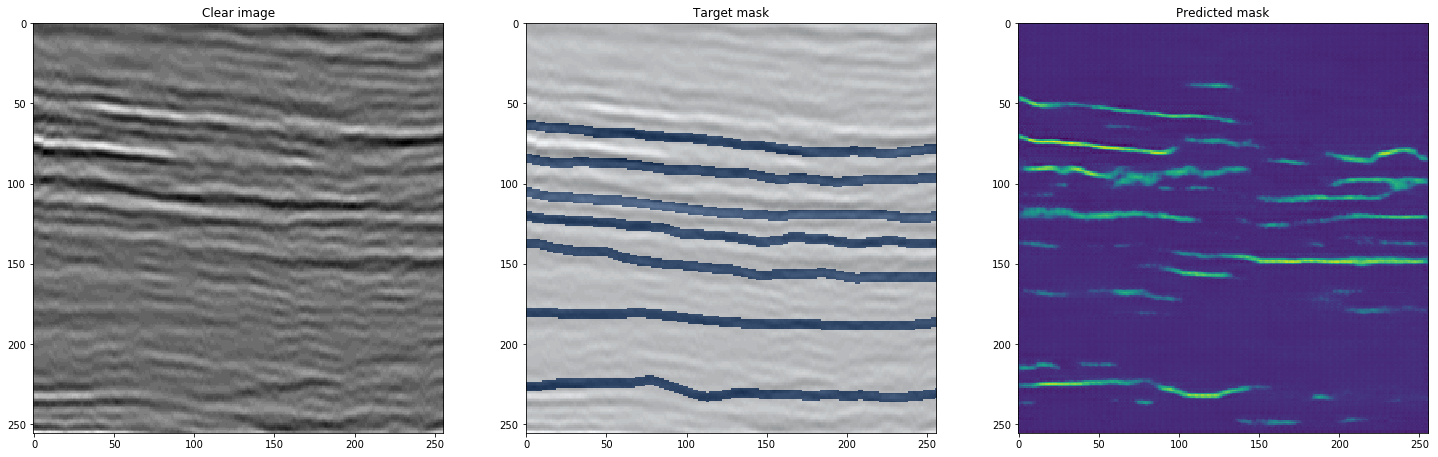

E_anon


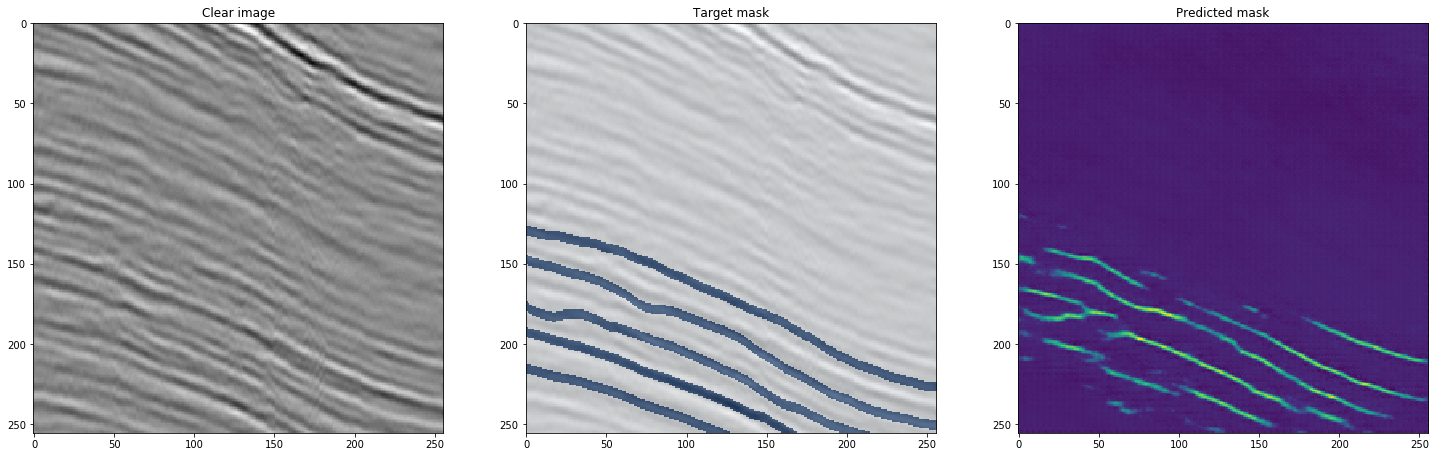

In [9]:
print('Loss is: ', val_pipeline.get_variable('result')[0][3])

for cube in np.random.choice(NUM_CROPS, 5):
    print(val_batch.indices[cube][:-10])
    iline = 0
    
    img =            val_pipeline.get_variable('result')[0][0][cube, :, :, iline].T
    masks =          val_pipeline.get_variable('result')[0][1][cube, :, :, iline, 0].T
    predicted_mask = val_pipeline.get_variable('result')[0][2][cube, :, :, iline, 0].T
    
    fig, ax = plt.subplots(1, 3, figsize=(25, 10))

    ax[0].imshow(img, cmap='gray')
    ax[0].set_title('Clear image')
    
    ax[1].imshow(masks, cmap="Blues")
    ax[1].imshow(img, cmap="gray", alpha=0.5)
    ax[1].imshow(masks, cmap="Blues", alpha=0.1)
    ax[1].set_title('Target mask')

    ax[2].imshow(predicted_mask)
    ax[2].set_title('Predicted mask')

    plt.show()

It is way easier to analyse results when multiple crops are aggregated back into bigger picture. Method `make_grid`, paired with action `assemble_crops`, does exactly that:

In [10]:
%%time
ds = ds.make_grid(ds.indices[0], CROP_SHAPE, 
                  [2201, 2202], [0, 800], [100, 1300],
                  strides=[1, 128, 128])

print('Shape of grid:', ds.grid_info['grid_array'].shape)

pred_pipeline = (Pipeline()
                 # Initialize everything
                 .init_variable('result_cubes', init_on_each_run=list())
                 .init_variable('result_masks', init_on_each_run=list())
                 .init_variable('result_preds', init_on_each_run=list())
                 .import_model('ED', train_pipeline)                 
                 # Load data/masks
                 .load_component(src=[D('geometries'), D('labels')],
                                 dst=['geometries', 'labels'])
                 .crop(points=L(D('grid_gen')),
                       shape=CROP_SHAPE)
                 .load_cubes(dst='data_crops')
                 .create_masks(dst='mask_crops')
                 .rotate_axes(src=['data_crops', 'mask_crops'])
                 .scale(mode='normalize', src='data_crops')
                 .add_axis(src='mask_crops')
                 # Predict with model, then aggregate
                 .predict_model('ED', 
                                fetches=['cubes', 'masks', 'predictions'],
                                make_data={'cubes': B('data_crops'), 'masks': B('mask_crops')}, 
                                save_to=[V('result_cubes', mode='e'), V('result_masks', mode='e'), V('result_preds', mode='e')])
                 .assemble_crops(src=V('result_cubes'), dst='assembled_cube',
                                   grid_info=D('grid_info'), mode='avg')
                 .assemble_crops(src=V('result_masks'), dst='assembled_mask',
                                   grid_info=D('grid_info'), mode='avg')
                 .assemble_crops(src=V('result_preds'), dst='assembled_pred',
                                   grid_info=D('grid_info'), mode='max')
                 ) << ds

for _ in range(ds.grid_iters):
    pred_batch = pred_pipeline.next_batch(3, n_epochs=None)

Shape of grid: (126, 3)
CPU times: user 12.8 s, sys: 1.98 s, total: 14.8 s
Wall time: 14.6 s


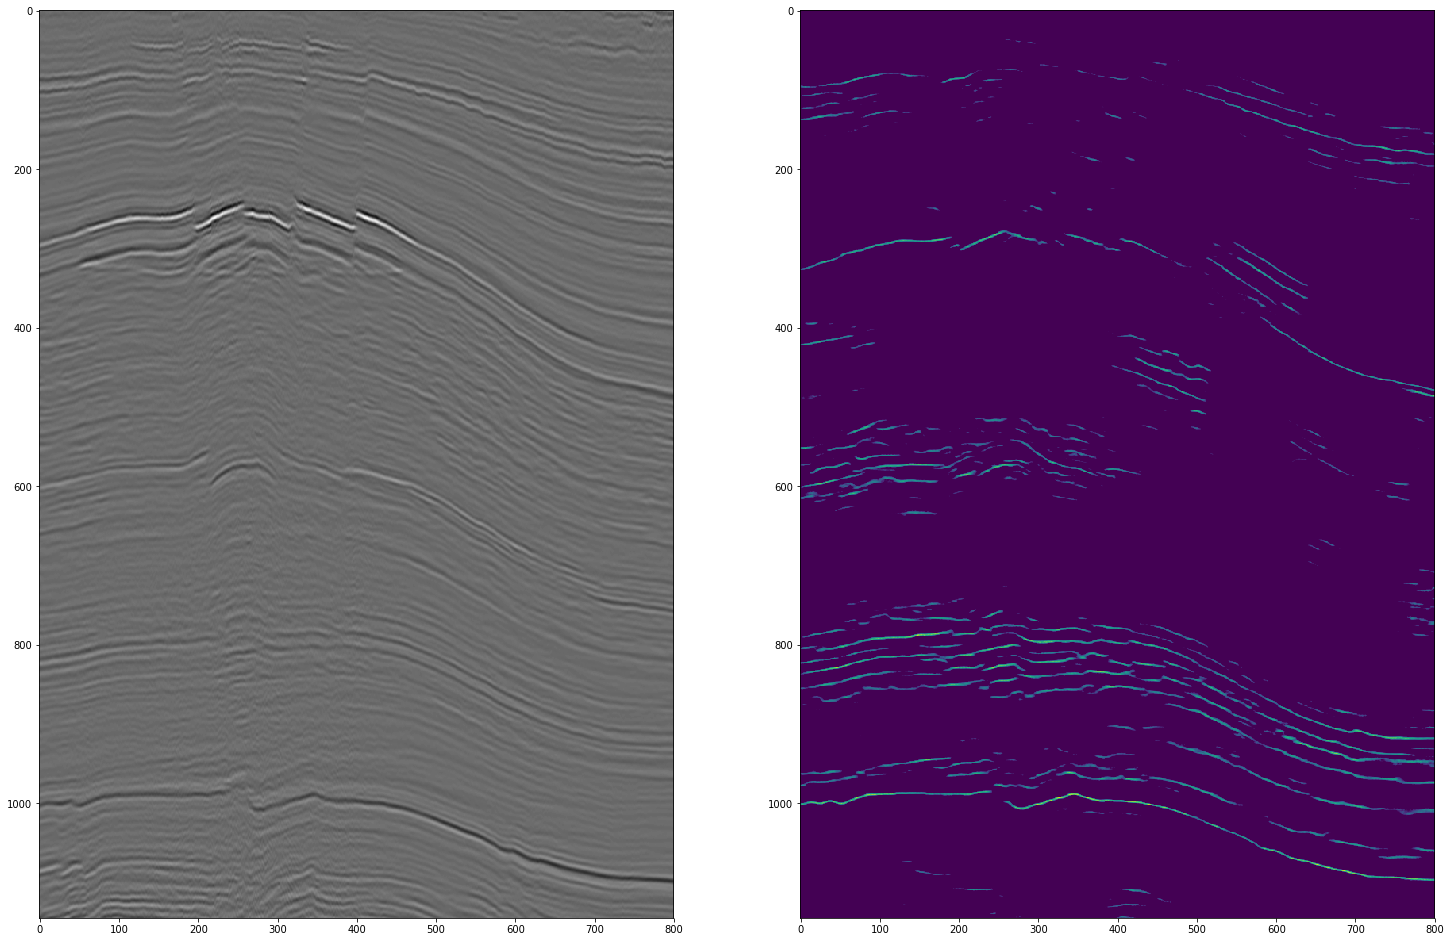

In [11]:
img_full = pred_batch.assembled_cube
pred_full = pred_batch.assembled_pred

fig, ax = plt.subplots(1, 2, figsize=(25, 25))
ax[0].imshow(img_full[0, :, :].T, cmap='gray')
ax[1].imshow(pred_full[0, :, :].T)
plt.show()

Note that `assemble_crops` takes action only once, when all of the crops are passed through the model. Also, this function can be quite memory intensive.

Due to slow changes in data along ilines in any given cube, it might be a good idea to test our model against completely new cube. To begin with, we need to load it:

In [12]:
%%time
test_path_data = '/notebooks/SEISMIC_DATA/CUBE_2/M_cube.hdf5'

test_dsi = FilesIndex(path=[test_path_data], no_ext=True)
test_ds = SeismicCubeset(test_dsi)

test_paths_txt = {test_ds.indices[0]: glob('/notebooks/SEISMIC_DATA/CUBE_2/HORIZONTS/*.txt')}

test_ds = (test_ds.load_geometries()
                  .load_point_clouds(paths = test_paths_txt)
                  .load_labels()
                  .load_samplers())
## ~ 4 seconds

CPU times: user 3.48 s, sys: 252 ms, total: 3.74 s
Wall time: 3.98 s


In [13]:
%%time
test_ds = test_ds.make_grid(test_ds.indices[0], CROP_SHAPE, 
                            [201, 202], [0, 800], [100, 1300],
                            strides=[1, 128, 128])

print('Shape of grid:', test_ds.grid_info['grid_array'].shape)

pred_pipeline = (Pipeline()
                 # Initialize everything
                 .init_variable('result_cubes', init_on_each_run=list())
                 .init_variable('result_masks', init_on_each_run=list())
                 .init_variable('result_preds', init_on_each_run=list())
                 .import_model('ED', train_pipeline)
                 # Load data/crops
                 .load_component(src=[D('geometries'), D('labels')],
                                 dst=['geometries', 'labels'])
                 .crop(points=L(D('grid_gen')),
                       shape=CROP_SHAPE)
                 .load_cubes(dst='data_crops')
                 .create_masks(dst='mask_crops')
                 .rotate_axes(src=['data_crops', 'mask_crops'])
                 .scale(mode='normalize', src='data_crops')
                 .add_axis(src='mask_crops')
                 # Predict with model, then aggregate
                 .predict_model('ED', 
                                fetches=['cubes', 'masks', 'predictions'],
                                make_data={'cubes': B('data_crops'), 'masks': B('mask_crops')}, 
                                save_to=[V('result_cubes', mode='e'), V('result_masks', mode='e'), V('result_preds', mode='e')])
                 .assemble_crops(src=V('result_cubes'), dst='assembled_cube',
                                   grid_info=D('grid_info'), mode='avg')
                 .assemble_crops(src=V('result_masks'), dst='assembled_mask',
                                   grid_info=D('grid_info'), mode='avg')
                 .assemble_crops(src=V('result_preds'), dst='assembled_pred',
                                   grid_info=D('grid_info'), mode='max')
                 ) << test_ds

for _ in range(test_ds.grid_iters):
    pred_batch = pred_pipeline.next_batch(1, n_epochs=None)

Shape of grid: (100, 3)
CPU times: user 8.33 s, sys: 1.07 s, total: 9.4 s
Wall time: 8.99 s


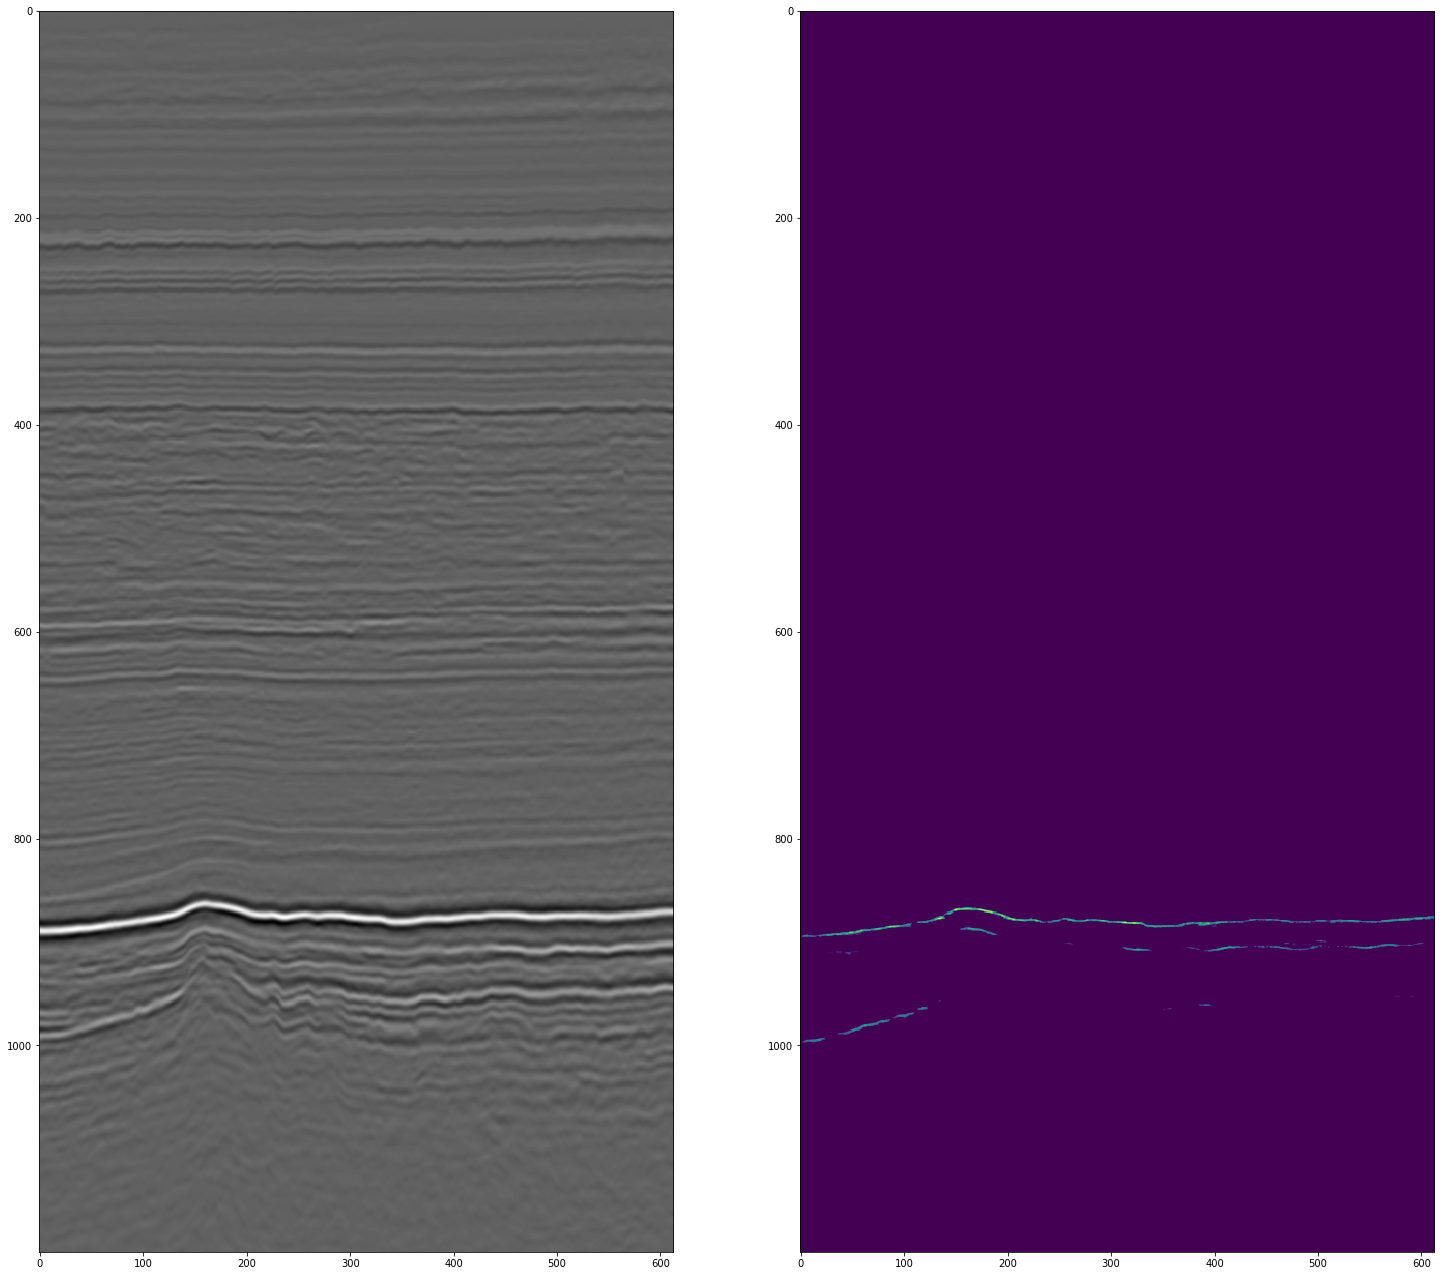

In [14]:
img_full = pred_batch.assembled_cube
pred_full = pred_batch.assembled_pred

fig, ax = plt.subplots(1, 2, figsize=(25, 25))
ax[0].imshow(img_full[0, :, :].T, cmap='gray')
ax[1].imshow(pred_full[0, :, :].T)
plt.show()

As we can see, even on completely new cube our model outputs reasonable horizonts.

Finally, it is time to save the model:

In [ ]:
save_dir = '/notebooks/SEISMIC_DATA/SAVED/MODELS/'
name = 'ED'

dir_ = save_dir + name + '/'
try:
    os.mkdir(dir_)
except FileExistsError:
    pass

def _convert(config):
    for key, value in config.items():
        if isinstance(value, dict):
            _convert(value)
        else:
            config[key] = str(value)

_convert(pipeline_config)
with open(dir_+'config.json', 'w') as f:
    json.dump(pipeline_config, f)


train_pipeline.save_model('ED', dir_)

<a id='criticism'></a>

In [ ]:
        './Segmenting_interlayers.ipynb.ipynb'

# Criticism

The task in hand is ill-defined: we don't know, how namy horizonts (and which) we want to predict. Despite that, this model serves as a great trampoline for the others: [horizont extension](./Horizons_extension.ipynb) and [facies segmentation](./Segmenting_interlayers.ipynb).

<a id='conclusion'></a>

# Conclusion

<a id='suggestions'></a>

# Suggestions for improvements

* add non-regular grid for assemble_crops

* improve conventions inside of the assemble_grid - DONE

* make whole end-to-end pipeline of model evaluation - DONE

* make `assemble_crop` memory stable: use disk space as background

* incorporate current features into notebook: `get_point_cloud`, better model configs, new format of labels, etc